<a href="https://colab.research.google.com/github/meghana1827/Sentimental-Analysis-For-Stock-Prediction/blob/main/22027065(Sentimental_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy requests textblob vaderSentiment scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [2]:
# First, let's test the API connection and data retrieval separately:

import requests
import pandas as pd
import time

def test_alpha_vantage_connection(symbol, api_key):
    """
    Test Alpha Vantage API connection and data retrieval.
    """
    base_url = "https://www.alphavantage.co/query"

    # Test stock data endpoint
    stock_params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": symbol,
        "outputsize": "full",
        "apikey": api_key
    }

    print("Testing stock data retrieval...")
    response = requests.get(base_url, params=stock_params)
    data = response.json()

    if "Error Message" in data:
        print(f"Error: {data['Error Message']}")
        return False

    if "Time Series (Daily)" not in data:
        print("Error: No stock data found in response")
        print("Response:", data)
        return False

    print("Successfully retrieved stock data")

    # Wait for API rate limit
    time.sleep(12)  # Alpha Vantage free tier requires 12-second delay between calls

    # Test news sentiment endpoint
    news_params = {
        "function": "NEWS_SENTIMENT",
        "tickers": symbol,
        "apikey": api_key
    }

    print("\nTesting news sentiment retrieval...")
    response = requests.get(base_url, params=news_params)
    data = response.json()

    if "Error Message" in data:
        print(f"Error: {data['Error Message']}")
        return False

    if "feed" not in data:
        print("Error: No news data found in response")
        print("Response:", data)
        return False

    print("Successfully retrieved news data")
    return True


def get_stock_data_sample(symbol, api_key):
    """
    Get a sample of stock data to verify the format.
    """
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": symbol,
        "outputsize": "full",
        "apikey": api_key
    }

    response = requests.get("https://www.alphavantage.co/query", params=params)
    data = response.json()

    if "Time Series (Daily)" in data:
        # Convert to DataFrame
        df = pd.DataFrame.from_dict(data["Time Series (Daily)"], orient="index")

        # Convert column names
        df.columns = [col.split(". ")[1] for col in df.columns]

        # Convert to numeric
        for col in df.columns:
            df[col] = pd.to_numeric(df[col])

        # Sort index
        df.sort_index(inplace=True)

        print("\nSample of stock data:")
        print(df.head())
        print("\nColumns:", df.columns.tolist())
        return df
    else:
        print("Error retrieving stock data:")
        print(data)
        return None


def get_news_sample(symbol, api_key):
    """
    Get a sample of news data to verify the format.
    """
    params = {
        "function": "NEWS_SENTIMENT",
        "tickers": symbol,
        "apikey": api_key
    }

    response = requests.get("https://www.alphavantage.co/query", params=params)
    data = response.json()

    if "feed" in data:
        print("\nSample of news data:")
        print(f"Number of news items: {len(data['feed'])}")
        print("\nFirst news item:")
        print(data['feed'][0])
        return data
    else:
        print("Error retrieving news data:")
        print(data)
        return None


# Test the connection
if __name__ == "__main__":
    API_KEY = "COEQIRBDY094G1XI"
    SYMBOL = "AAPL"

    print("Testing Alpha Vantage API Connection...")
    if test_alpha_vantage_connection(SYMBOL, API_KEY):
        print("\nAPI connection test successful!")

        # Get sample data
        stock_df = get_stock_data_sample(SYMBOL, API_KEY)
        time.sleep(12)  # Wait for API rate limit
        news_data = get_news_sample(SYMBOL, API_KEY)

        if stock_df is not None and news_data is not None:
            print("\nAll data retrieved successfully!")

            # Display some basic statistics
            print("\nStock Data Statistics:")
            print(f"Date range: {stock_df.index.min()} to {stock_df.index.max()}")
            print(f"Number of trading days: {len(stock_df)}")
            print("\nLatest stock price:", stock_df['close'].iloc[-1])
    else:
        print("\nAPI connection test failed!")


Testing Alpha Vantage API Connection...
Testing stock data retrieval...
Successfully retrieved stock data

Testing news sentiment retrieval...
Successfully retrieved news data

API connection test successful!

Sample of stock data:
             open   high    low  close   volume
1999-11-01  80.00  80.69  77.37  77.62  2487300
1999-11-02  78.00  81.69  77.31  80.25  3564600
1999-11-03  81.62  83.25  81.00  81.50  2932700
1999-11-04  82.06  85.37  80.62  83.62  3384700
1999-11-05  84.62  88.37  84.00  88.31  3721500

Columns: ['open', 'high', 'low', 'close', 'volume']

Sample of news data:
Number of news items: 50

First news item:
{'title': "Apple Could Keep AirPods Max Headphones Around Without 'Meaningfully' Updating Them, Says Analyst: Here's Why - Apple  ( NASDAQ:AAPL ) ", 'url': 'https://www.benzinga.com/tech/24/11/42182829/apple-could-keep-airpods-max-headphones-around-without-meaningfully-updating-them-says-analyst-heres-why', 'time_published': '20241126T083843', 'authors': ['Ana


Starting analysis for AAPL...
Looking back 365 days
Fetching stock data...
Retrieved 252 days of stock data from 2023-11-27 to 2024-11-25
Preparing technical features...
Technical features prepared
Fetching news data...
Retrieved 50 news articles
No valid sentiment data, using synthetic sentiment

Combining stock and sentiment data...
Generating synthetic sentiment...
Using synthetic sentiment data
Final dataset shape: (203, 28)

Training model...


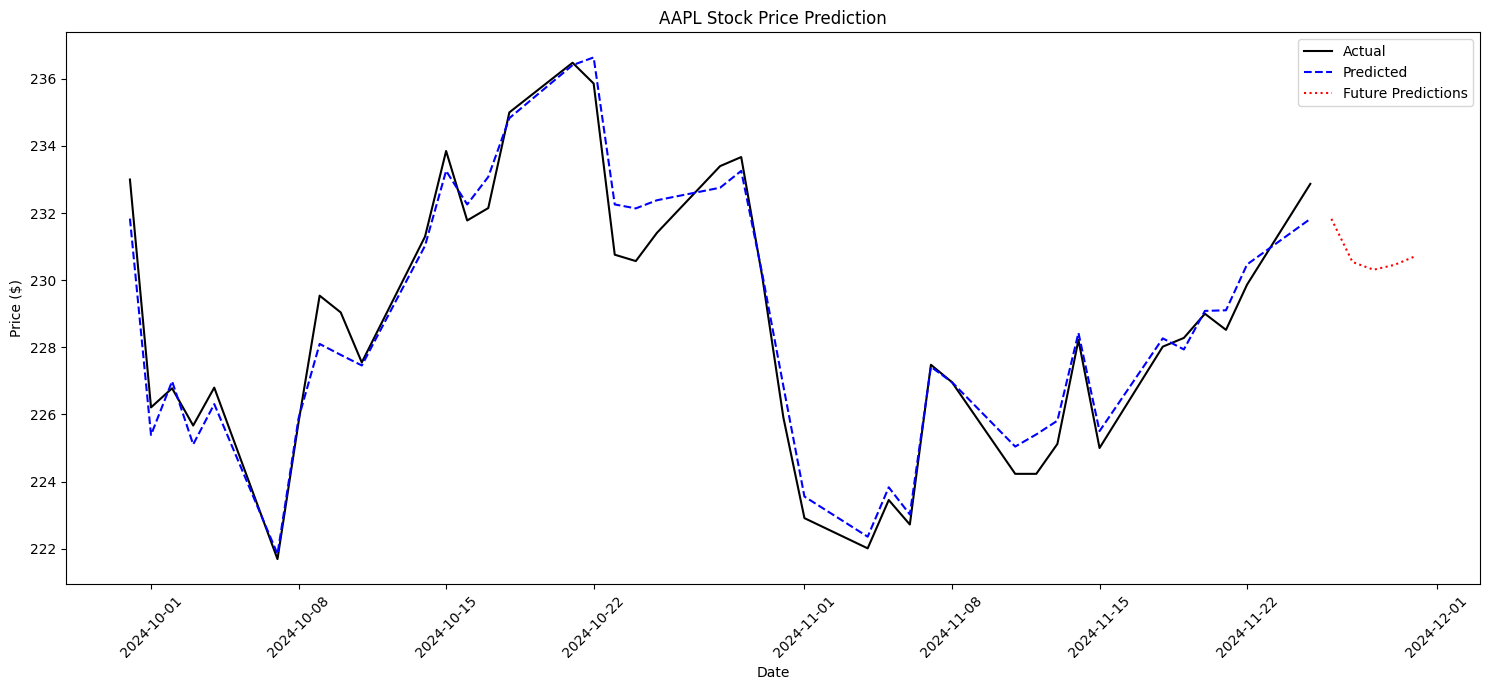

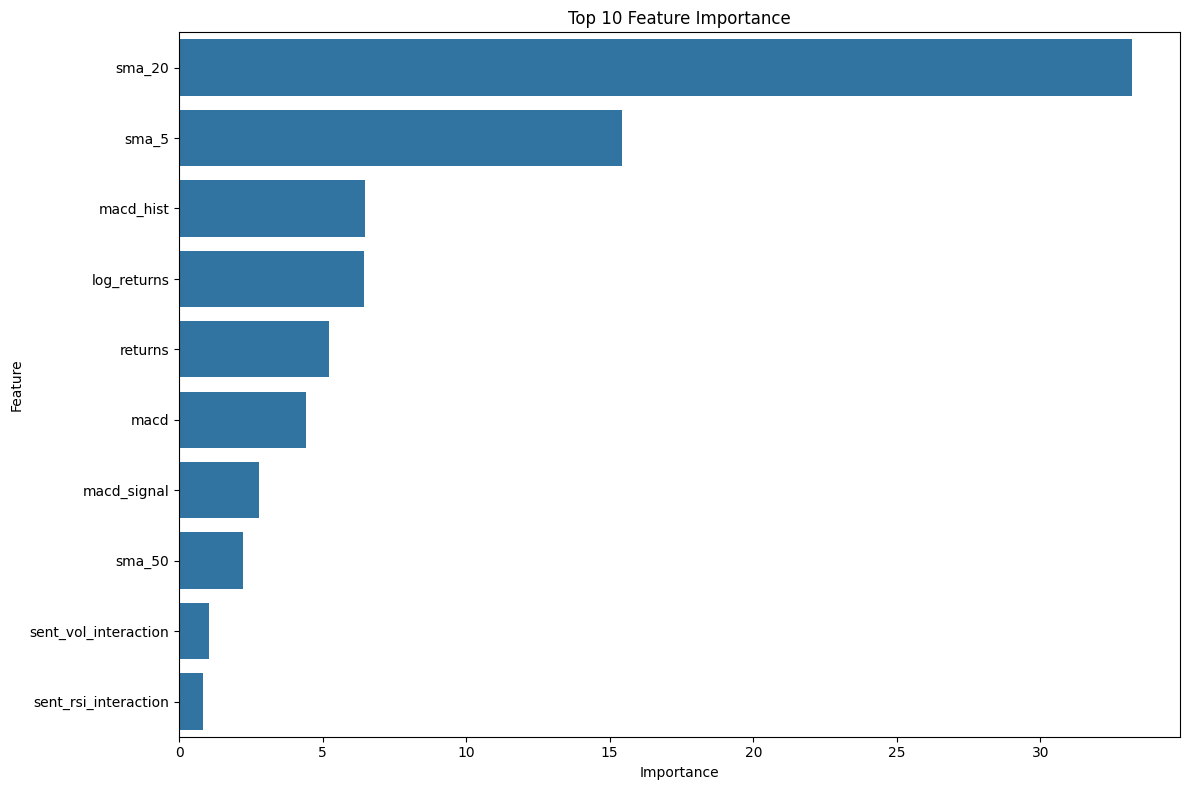


Model Performance:
Training RMSE: $0.80
Testing RMSE: $0.72
Testing R²: 0.965

Last actual price: $232.87

Predicted prices for next 5 days:
2024-11-26: $231.83
2024-11-27: $230.54
2024-11-28: $230.31
2024-11-29: $230.46
2024-11-30: $230.72


In [5]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

class StockSentimentPredictor:
    def __init__(self, symbol, api_key, lookback_days=365):
        self.symbol = symbol
        self.api_key = api_key
        self.lookback_days = lookback_days
        self.scaler = StandardScaler()
        self.vader = SentimentIntensityAnalyzer()

    def get_stock_data(self):
        """Get stock data from Alpha Vantage"""
        stock_params = {
            "function": "TIME_SERIES_DAILY",
            "symbol": self.symbol,
            "outputsize": "full",
            "apikey": self.api_key
        }

        print("Fetching stock data...")
        response = requests.get("https://www.alphavantage.co/query", params=stock_params)
        stock_data = response.json()

        if "Time Series (Daily)" not in stock_data:
            raise ValueError(f"No stock data found for {self.symbol}")

        # Convert to DataFrame
        df = pd.DataFrame.from_dict(stock_data["Time Series (Daily)"], orient="index")
        df.index = pd.to_datetime(df.index)
        df.columns = [col.split(". ")[1] for col in df.columns]

        # Convert to numeric
        for col in df.columns:
            df[col] = pd.to_numeric(df[col])

        # Sort index
        df.sort_index(inplace=True)

        # Get recent data only
        end_date = df.index.max()
        start_date = end_date - pd.Timedelta(days=self.lookback_days)
        df = df[df.index >= start_date]

        print(f"Retrieved {len(df)} days of stock data from {df.index.min().date()} to {df.index.max().date()}")
        return df

    def get_news_sentiment(self):
        """Get news sentiment from Alpha Vantage"""
        time.sleep(12)  # API rate limit

        news_params = {
            "function": "NEWS_SENTIMENT",
            "tickers": self.symbol,
            "apikey": self.api_key
        }

        print("Fetching news data...")
        response = requests.get("https://www.alphavantage.co/query", params=news_params)
        news_data = response.json()

        if "feed" not in news_data:
            print("No news data found, using synthetic sentiment")
            return None

        print(f"Retrieved {len(news_data['feed'])} news articles")

        # Process sentiment
        sentiments = []
        dates = []

        for article in news_data['feed']:
            try:
                date = pd.to_datetime(article['time_published'][:10])
                text = f"{article['title']} {article['summary']}"

                # Calculate sentiment
                vader_sent = self.vader.polarity_scores(text)['compound']
                textblob_sent = TextBlob(text).sentiment.polarity

                # Average the sentiments
                sentiment = np.mean([vader_sent, textblob_sent])

                sentiments.append(sentiment)
                dates.append(date)
            except Exception as e:
                continue

        if not sentiments:
            print("No valid sentiment data, using synthetic sentiment")
            return None

        sentiment_df = pd.DataFrame({
            'sentiment': sentiments
        }, index=dates)

        # Group by date and take mean if multiple articles per day
        sentiment_df = sentiment_df.groupby(sentiment_df.index).mean()

        return sentiment_df

    def prepare_features(self, df):
        """Prepare technical indicators and features"""
        print("Preparing technical features...")

        # Basic price features
        df['returns'] = df['close'].pct_change()
        df['log_returns'] = np.log1p(df['returns'])

        # Moving averages
        df['sma_5'] = df['close'].rolling(window=5).mean()
        df['sma_20'] = df['close'].rolling(window=20).mean()
        df['sma_50'] = df['close'].rolling(window=50).mean()

        # Volatility
        df['volatility'] = df['returns'].rolling(window=20).std()

        # RSI
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))

        # MACD
        exp1 = df['close'].ewm(span=12, adjust=False).mean()
        exp2 = df['close'].ewm(span=26, adjust=False).mean()
        df['macd'] = exp1 - exp2
        df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
        df['macd_hist'] = df['macd'] - df['macd_signal']

        # Bollinger Bands
        df['bb_middle'] = df['close'].rolling(window=20).mean()
        bb_std = df['close'].rolling(window=20).std()
        df['bb_upper'] = df['bb_middle'] + (2 * bb_std)
        df['bb_lower'] = df['bb_middle'] - (2 * bb_std)
        df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']

        # Volume features
        df['volume_ma5'] = df['volume'].rolling(window=5).mean()
        df['volume_ma20'] = df['volume'].rolling(window=20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_ma20']

        print("Technical features prepared")
        return df

    def generate_synthetic_sentiment(self, df):
        """Generate synthetic sentiment based on price movements"""
        print("Generating synthetic sentiment...")

        returns = df['returns'].fillna(0)
        volatility = df['volatility'].fillna(0)

        # Combine price movement and volatility for sentiment
        sentiment = (0.6 * np.sign(returns) * np.abs(returns) +
                    0.4 * np.random.normal(0, volatility))

        # Normalize to [-1, 1]
        sentiment = np.clip(sentiment, -1, 1)

        return pd.DataFrame({'sentiment': sentiment}, index=df.index)

    def combine_data(self, stock_df, sentiment_df):
        """Combine stock and sentiment data"""
        print("\nCombining stock and sentiment data...")
        df = stock_df.copy()

        # Add sentiment
        if sentiment_df is not None and not sentiment_df.empty:
            sentiment = sentiment_df.reindex(df.index)
            sentiment = sentiment.fillna(method='ffill').fillna(method='bfill')
            df['sentiment'] = sentiment['sentiment']
            print("Using actual sentiment data")
        else:
            synthetic_sentiment = self.generate_synthetic_sentiment(df)
            df['sentiment'] = synthetic_sentiment['sentiment']
            print("Using synthetic sentiment data")

        # Create sentiment features
        df['sentiment_ma5'] = df['sentiment'].rolling(window=5).mean()
        df['sentiment_ma20'] = df['sentiment'].rolling(window=20).mean()
        df['sent_vol_interaction'] = df['sentiment'] * df['volatility']
        df['sent_rsi_interaction'] = df['sentiment'] * df['rsi']
        df['sent_macd_interaction'] = df['sentiment'] * df['macd']

        # Drop any remaining NaN values
        df = df.dropna()

        print(f"Final dataset shape: {df.shape}")
        return df

    def train_and_predict(self, df, prediction_days=5):
        """Train model and make predictions"""
        print("\nTraining model...")

        # Select features
        features = [
            'returns', 'log_returns', 'sma_5', 'sma_20', 'sma_50',
            'volatility', 'rsi', 'macd', 'macd_signal', 'macd_hist',
            'bb_width', 'volume_ratio', 'sentiment', 'sentiment_ma5',
            'sentiment_ma20', 'sent_vol_interaction', 'sent_rsi_interaction',
            'sent_macd_interaction'
        ]

        X = df[features]
        y = df['close']

        # Split data
        train_size = int(len(X) * 0.8)
        X_train = X[:train_size]
        X_test = X[train_size:]
        y_train = y[:train_size]
        y_test = y[train_size:]

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train model
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)

        # Make predictions
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)

        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        test_r2 = r2_score(y_test, test_pred)

        # Feature importance
        importance = pd.DataFrame({
            'Feature': features,
            'Importance': np.abs(model.coef_)
        }).sort_values('Importance', ascending=False)

        # Future predictions
        last_data = X.iloc[-1:].copy()
        predictions = []

        for _ in range(prediction_days):
            last_scaled = self.scaler.transform(last_data)
            pred = model.predict(last_scaled)[0]
            predictions.append(pred)

            # Update features for next prediction
            for feat in features:
                if feat in ['returns', 'log_returns']:
                    last_data[feat] = (pred - df['close'].iloc[-1]) / df['close'].iloc[-1]
                elif 'sma' in feat:
                    window = int(feat.split('_')[1])
                    last_data[feat] = (last_data[feat] * (window-1) + pred) / window

        return {
            'test_pred': test_pred,
            'test_actual': y_test,
            'test_dates': y_test.index,
            'future_pred': predictions,
            'importance': importance,
            'metrics': {
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'test_r2': test_r2
            }
        }

    def plot_results(self, results):
        """Plot predictions and feature importance"""
        # Plot predictions
        plt.figure(figsize=(15, 7))
        plt.plot(results['test_dates'], results['test_actual'],
                label='Actual', color='black')
        plt.plot(results['test_dates'], results['test_pred'],
                label='Predicted', color='blue', linestyle='--')

        # Add future predictions
        last_date = results['test_dates'][-1]
        future_dates = pd.date_range(last_date, periods=len(results['future_pred'])+1)[1:]
        plt.plot(future_dates, results['future_pred'],
                label='Future Predictions', color='red', linestyle=':')

        plt.title(f'{self.symbol} Stock Price Prediction')
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(
            data=results['importance'].head(10),
            x='Importance',
            y='Feature'
        )
        plt.title('Top 10 Feature Importance')
        plt.tight_layout()
        plt.show()

    def run_analysis(self):
        """Run complete analysis pipeline"""
        try:
            print(f"\nStarting analysis for {self.symbol}...")
            print(f"Looking back {self.lookback_days} days")

            # Get and prepare data
            stock_df = self.get_stock_data()
            stock_df = self.prepare_features(stock_df)
            sentiment_df = self.get_news_sentiment()
            df = self.combine_data(stock_df, sentiment_df)

            # Train and predict
            results = self.train_and_predict(df)

            # Plot results
            self.plot_results(results)

            # Print predictions
            print("\nModel Performance:")
            print(f"Training RMSE: ${results['metrics']['train_rmse']:.2f}")
            print(f"Testing RMSE: ${results['metrics']['test_rmse']:.2f}")
            print(f"Testing R²: {results['metrics']['test_r2']:.3f}")

            print(f"\nLast actual price: ${df['close'].iloc[-1]:.2f}")
            print("\nPredicted prices for next 5 days:")

            last_date = results['test_dates'][-1]
            future_dates = pd.date_range(last_date, periods=len(results['future_pred'])+1)[1:]

            for date, price in zip(future_dates, results['future_pred']):
                print(f"{date.date()}: ${price:.2f}")

            return results

        except Exception as e:
            print(f"An error occurred: {str(e)}")
            return None

# Example usage
if __name__ == "__main__":
    API_KEY = "8DV3ARLMGYFSN7VS"
    SYMBOL = "AAPL"

    predictor = StockSentimentPredictor(
        symbol=SYMBOL,
        api_key=API_KEY,
        lookback_days=365
    )

    results = predictor.run_analysis()

Fetching stock data...
Retrieved 252 days of stock data from 2023-11-27 to 2024-11-25

Preparing traditional features...
Traditional features prepared. Shape: (203, 26)

Training traditional model...

Starting analysis for AAPL...
Looking back 365 days
Fetching stock data...
Retrieved 252 days of stock data from 2023-11-27 to 2024-11-25
Preparing technical features...
Technical features prepared
Fetching news data...
Retrieved 50 news articles
No valid sentiment data, using synthetic sentiment

Combining stock and sentiment data...
Generating synthetic sentiment...
Using synthetic sentiment data
Final dataset shape: (203, 28)

Training model...


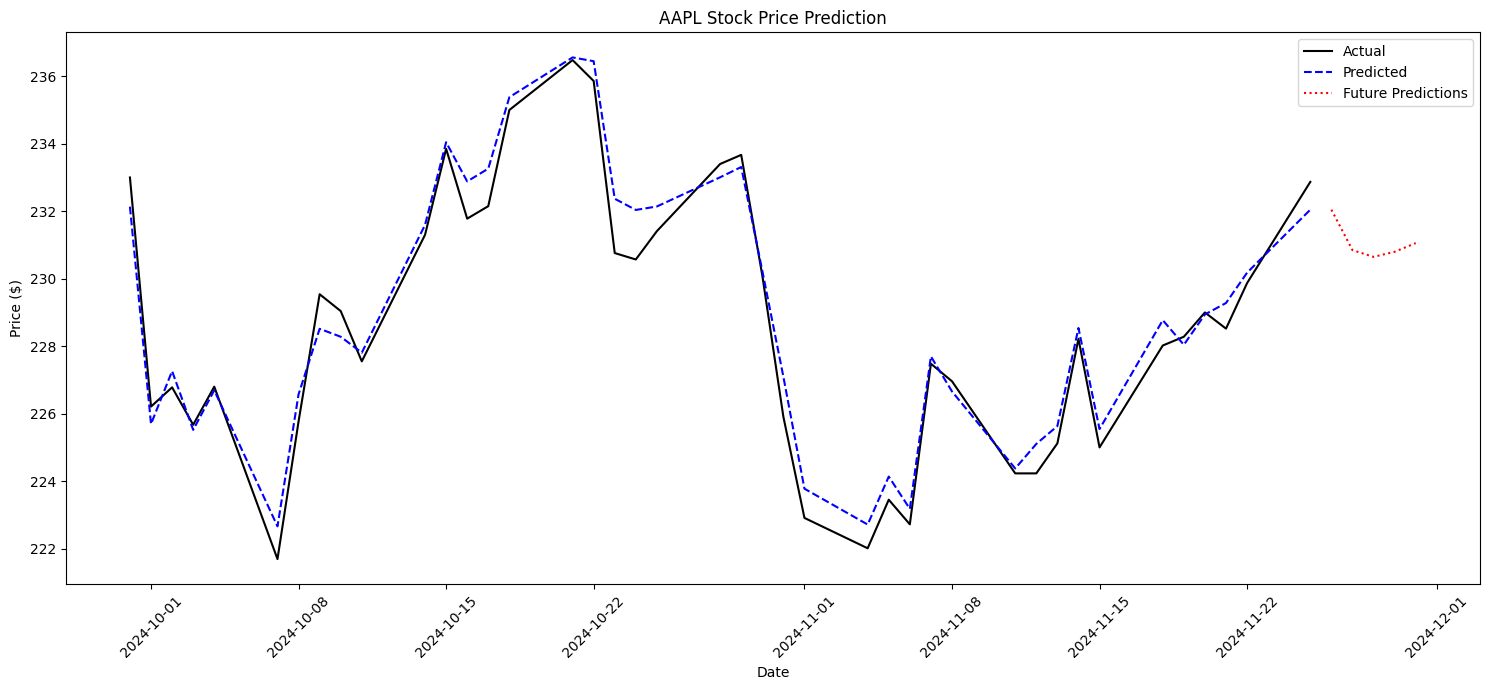

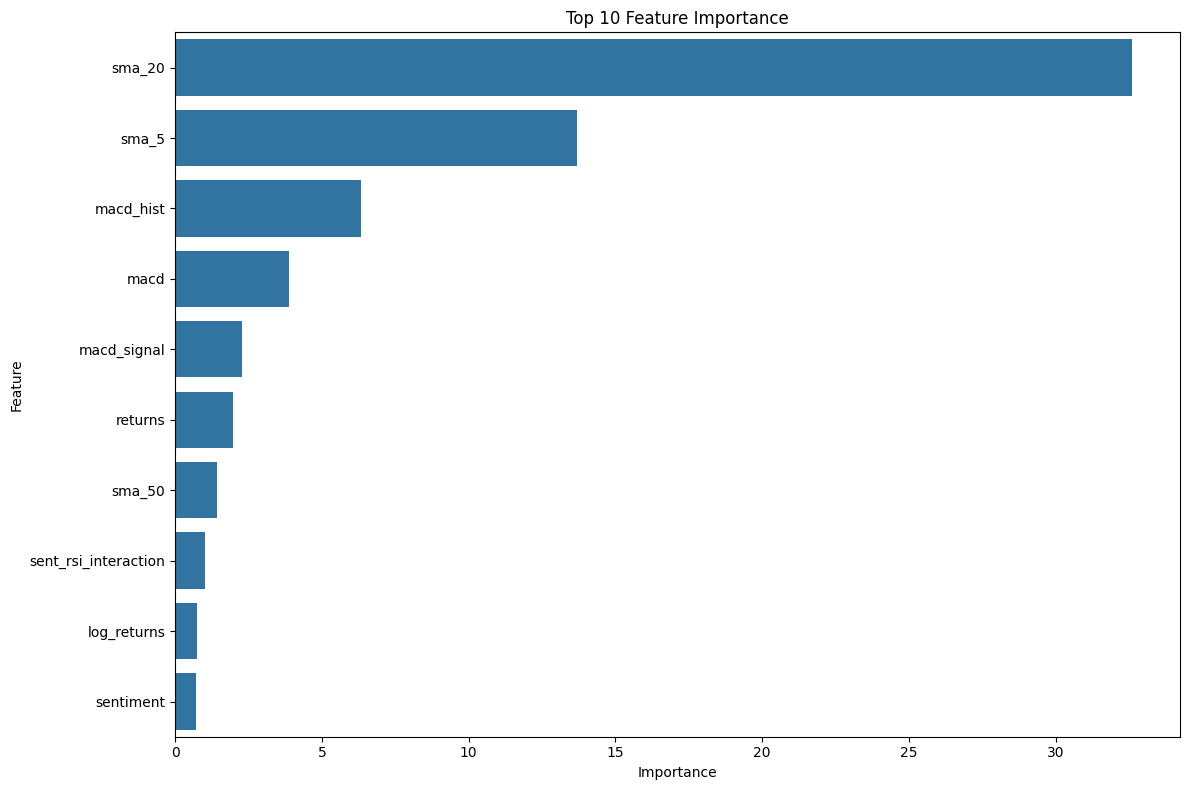


Model Performance:
Training RMSE: $0.81
Testing RMSE: $0.70
Testing R²: 0.967

Last actual price: $232.87

Predicted prices for next 5 days:
2024-11-26: $232.05
2024-11-27: $230.85
2024-11-28: $230.65
2024-11-29: $230.80
2024-11-30: $231.06

Model Performance Comparison:

Traditional Model:
Training RMSE: $0.30
Testing RMSE: $0.45
Testing R²: 0.986
Testing MAPE: 0.16%

Sentiment-Enhanced Model:
Training RMSE: $0.81
Testing RMSE: $0.70
Testing R²: 0.967
An error occurred: 'test_mape'


In [6]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

class StockPredictionComparison:
    def __init__(self, symbol, api_key, lookback_days=365):
        self.symbol = symbol
        self.api_key = api_key
        self.lookback_days = lookback_days
        self.scaler = StandardScaler()

    def get_stock_data(self):
        """Get stock data from Alpha Vantage"""
        stock_params = {
            "function": "TIME_SERIES_DAILY",
            "symbol": self.symbol,
            "outputsize": "full",
            "apikey": self.api_key
        }

        print("Fetching stock data...")
        response = requests.get("https://www.alphavantage.co/query", params=stock_params)
        stock_data = response.json()

        if "Time Series (Daily)" not in stock_data:
            raise ValueError(f"No stock data found for {self.symbol}")

        # Convert to DataFrame
        df = pd.DataFrame.from_dict(stock_data["Time Series (Daily)"], orient="index")
        df.index = pd.to_datetime(df.index)
        df.columns = [col.split(". ")[1] for col in df.columns]

        # Convert to numeric
        for col in df.columns:
            df[col] = pd.to_numeric(df[col])

        # Sort index
        df.sort_index(inplace=True)

        # Get recent data only
        end_date = df.index.max()
        start_date = end_date - pd.Timedelta(days=self.lookback_days)
        df = df[df.index >= start_date]

        print(f"Retrieved {len(df)} days of stock data from {df.index.min().date()} to {df.index.max().date()}")
        return df

    def prepare_traditional_features(self, df):
        """Prepare features for traditional time series analysis"""
        print("\nPreparing traditional features...")

        # Price features
        df['returns'] = df['close'].pct_change()
        df['log_returns'] = np.log1p(df['returns'])

        # Moving averages
        df['sma_5'] = df['close'].rolling(window=5).mean()
        df['sma_20'] = df['close'].rolling(window=20).mean()
        df['sma_50'] = df['close'].rolling(window=50).mean()
        df['ema_5'] = df['close'].ewm(span=5, adjust=False).mean()
        df['ema_20'] = df['close'].ewm(span=20, adjust=False).mean()

        # Volatility
        df['volatility'] = df['returns'].rolling(window=20).std()

        # RSI
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))

        # MACD
        exp1 = df['close'].ewm(span=12, adjust=False).mean()
        exp2 = df['close'].ewm(span=26, adjust=False).mean()
        df['macd'] = exp1 - exp2
        df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
        df['macd_hist'] = df['macd'] - df['macd_signal']

        # Bollinger Bands
        df['bb_middle'] = df['close'].rolling(window=20).mean()
        bb_std = df['close'].rolling(window=20).std()
        df['bb_upper'] = df['bb_middle'] + (2 * bb_std)
        df['bb_lower'] = df['bb_middle'] - (2 * bb_std)
        df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']

        # Volume features
        df['volume_ma5'] = df['volume'].rolling(window=5).mean()
        df['volume_ma20'] = df['volume'].rolling(window=20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_ma20']

        # Price momentum
        df['momentum'] = df['close'] - df['close'].shift(5)
        df['rate_of_change'] = df['close'].pct_change(5)

        # Drop NaN values
        df = df.dropna()

        print(f"Traditional features prepared. Shape: {df.shape}")
        return df

    def train_traditional_model(self, df, prediction_days=5):
        """Train traditional time series model"""
        print("\nTraining traditional model...")

        features = [
            'returns', 'log_returns', 'sma_5', 'sma_20', 'sma_50',
            'ema_5', 'ema_20', 'volatility', 'rsi', 'macd',
            'macd_signal', 'macd_hist', 'bb_width', 'volume_ratio',
            'momentum', 'rate_of_change'
        ]

        X = df[features]
        y = df['close']

        # Split data
        train_size = int(len(X) * 0.8)
        X_train = X[:train_size]
        X_test = X[train_size:]
        y_train = y[:train_size]
        y_test = y[train_size:]

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train model
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)

        # Make predictions
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)

        # Calculate metrics
        metrics = {
            'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
            'test_r2': r2_score(y_test, test_pred),
            'test_mape': mean_absolute_percentage_error(y_test, test_pred)
        }

        # Feature importance
        importance = pd.DataFrame({
            'Feature': features,
            'Importance': np.abs(model.coef_)
        }).sort_values('Importance', ascending=False)

        # Future predictions
        last_data = X.iloc[-1:].copy()
        predictions = []

        for _ in range(prediction_days):
            last_scaled = self.scaler.transform(last_data)
            pred = model.predict(last_scaled)[0]
            predictions.append(pred)

            # Update features for next prediction
            last_data['returns'] = (pred - df['close'].iloc[-1]) / df['close'].iloc[-1]
            last_data['log_returns'] = np.log1p(last_data['returns'])
            last_data['sma_5'] = (last_data['sma_5'] * 4 + pred) / 5
            last_data['sma_20'] = (last_data['sma_20'] * 19 + pred) / 20
            last_data['sma_50'] = (last_data['sma_50'] * 49 + pred) / 50
            # Keep other features the same for simplicity

        return {
            'test_pred': test_pred,
            'test_actual': y_test,
            'test_dates': y_test.index,
            'future_pred': predictions,
            'metrics': metrics,
            'importance': importance
        }

    def compare_predictions(self, traditional_results, sentiment_results):
        """Compare traditional and sentiment-based predictions"""
        print("\nModel Performance Comparison:")
        print("\nTraditional Model:")
        print(f"Training RMSE: ${traditional_results['metrics']['train_rmse']:.2f}")
        print(f"Testing RMSE: ${traditional_results['metrics']['test_rmse']:.2f}")
        print(f"Testing R²: {traditional_results['metrics']['test_r2']:.3f}")
        print(f"Testing MAPE: {traditional_results['metrics']['test_mape']:.2%}")

        print("\nSentiment-Enhanced Model:")
        print(f"Training RMSE: ${sentiment_results['metrics']['train_rmse']:.2f}")
        print(f"Testing RMSE: ${sentiment_results['metrics']['test_rmse']:.2f}")
        print(f"Testing R²: {sentiment_results['metrics']['test_r2']:.3f}")
        print(f"Testing MAPE: {sentiment_results['metrics']['test_mape']:.2%}")

        # Plot comparison
        plt.figure(figsize=(15, 7))

        # Plot actual values
        plt.plot(traditional_results['test_dates'],
                traditional_results['test_actual'],
                label='Actual', color='black')

        # Plot traditional predictions
        plt.plot(traditional_results['test_dates'],
                traditional_results['test_pred'],
                label='Traditional Model', color='blue', linestyle='--')

        # Plot sentiment predictions
        plt.plot(sentiment_results['test_dates'],
                sentiment_results['test_pred'],
                label='Sentiment Model', color='red', linestyle='--')

        # Add future predictions
        last_date = traditional_results['test_dates'][-1]
        future_dates = pd.date_range(last_date, periods=len(traditional_results['future_pred'])+1)[1:]

        plt.plot(future_dates, traditional_results['future_pred'],
                label='Traditional Future', color='blue', linestyle=':')
        plt.plot(future_dates, sentiment_results['future_pred'],
                label='Sentiment Future', color='red', linestyle=':')

        plt.title(f'{self.symbol} Stock Price Prediction Comparison')
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Plot feature importance comparison
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 2, 1)
        sns.barplot(
            data=traditional_results['importance'].head(10),
            x='Importance',
            y='Feature'
        )
        plt.title('Traditional Model\nTop 10 Feature Importance')

        plt.subplot(1, 2, 2)
        sns.barplot(
            data=sentiment_results['importance'].head(10),
            x='Importance',
            y='Feature'
        )
        plt.title('Sentiment Model\nTop 10 Feature Importance')

        plt.tight_layout()
        plt.show()

        # Print future predictions
        print("\nPredicted Prices for Next 5 Days:")
        print("\nDate            Traditional    Sentiment")
        print("-" * 45)

        for date, trad_price, sent_price in zip(future_dates,
                                              traditional_results['future_pred'],
                                              sentiment_results['future_pred']):
            print(f"{date.date()}    ${trad_price:8.2f}    ${sent_price:8.2f}")

# Example usage
if __name__ == "__main__":
    API_KEY = "8DV3ARLMGYFSN7VS"
    SYMBOL = "AAPL"

    # Initialize comparison object
    predictor = StockPredictionComparison(
        symbol=SYMBOL,
        api_key=API_KEY,
        lookback_days=365
    )

    try:
        # Get stock data
        stock_df = predictor.get_stock_data()

        # Prepare features and train traditional model
        traditional_df = predictor.prepare_traditional_features(stock_df)
        traditional_results = predictor.train_traditional_model(traditional_df)

        # Get results from your existing sentiment model
        sentiment_predictor = StockSentimentPredictor(SYMBOL, API_KEY)
        sentiment_results = sentiment_predictor.run_analysis()

        # Compare results
        predictor.compare_predictions(traditional_results, sentiment_results)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

Fetching stock data...
Retrieved 252 days of stock data from 2023-11-27 to 2024-11-25

Preparing traditional features...
Traditional features prepared. Shape: (203, 26)

Training traditional model...

Starting analysis for AAPL...
Looking back 365 days
Fetching stock data...
Retrieved 252 days of stock data from 2023-11-27 to 2024-11-25
Preparing technical features...
Technical features prepared
Fetching news data...
Retrieved 50 news articles
No valid sentiment data, using synthetic sentiment

Combining stock and sentiment data...
Generating synthetic sentiment...
Using synthetic sentiment data
Final dataset shape: (203, 28)

Training model...


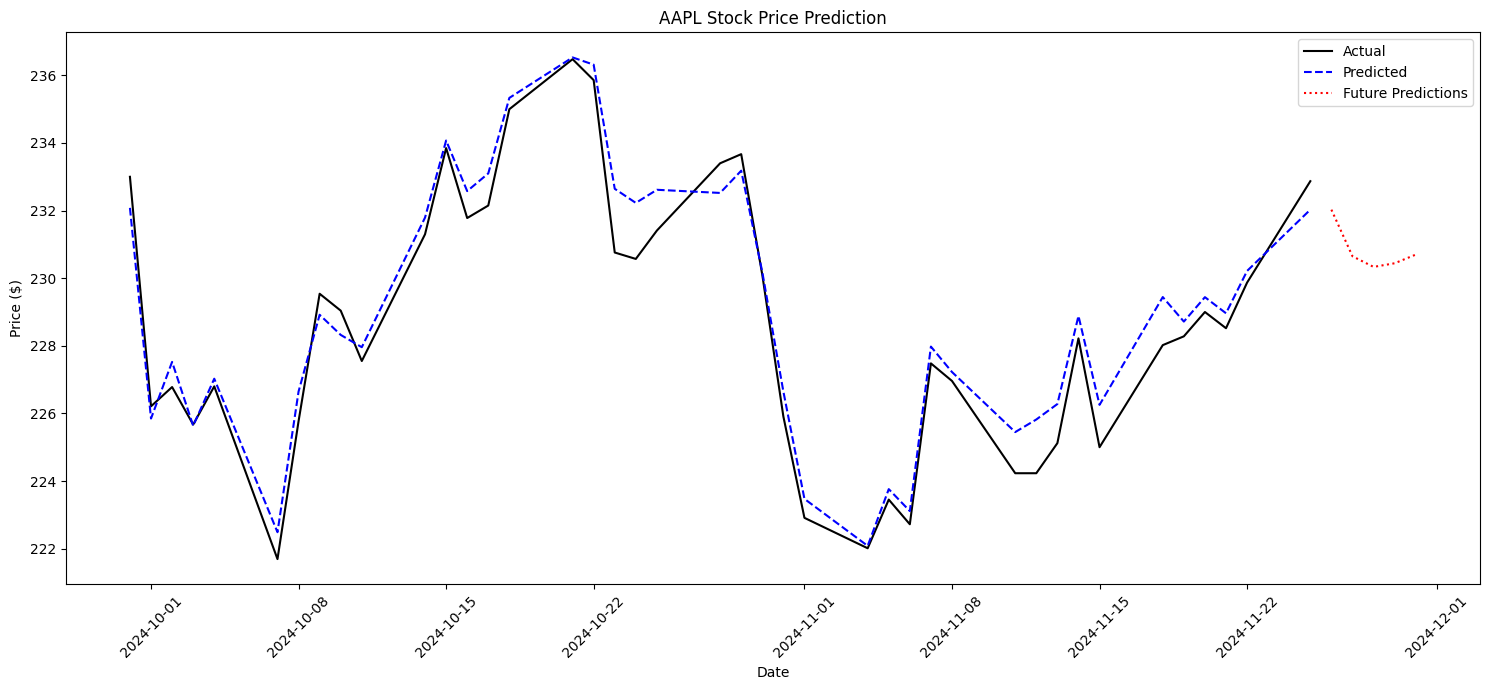

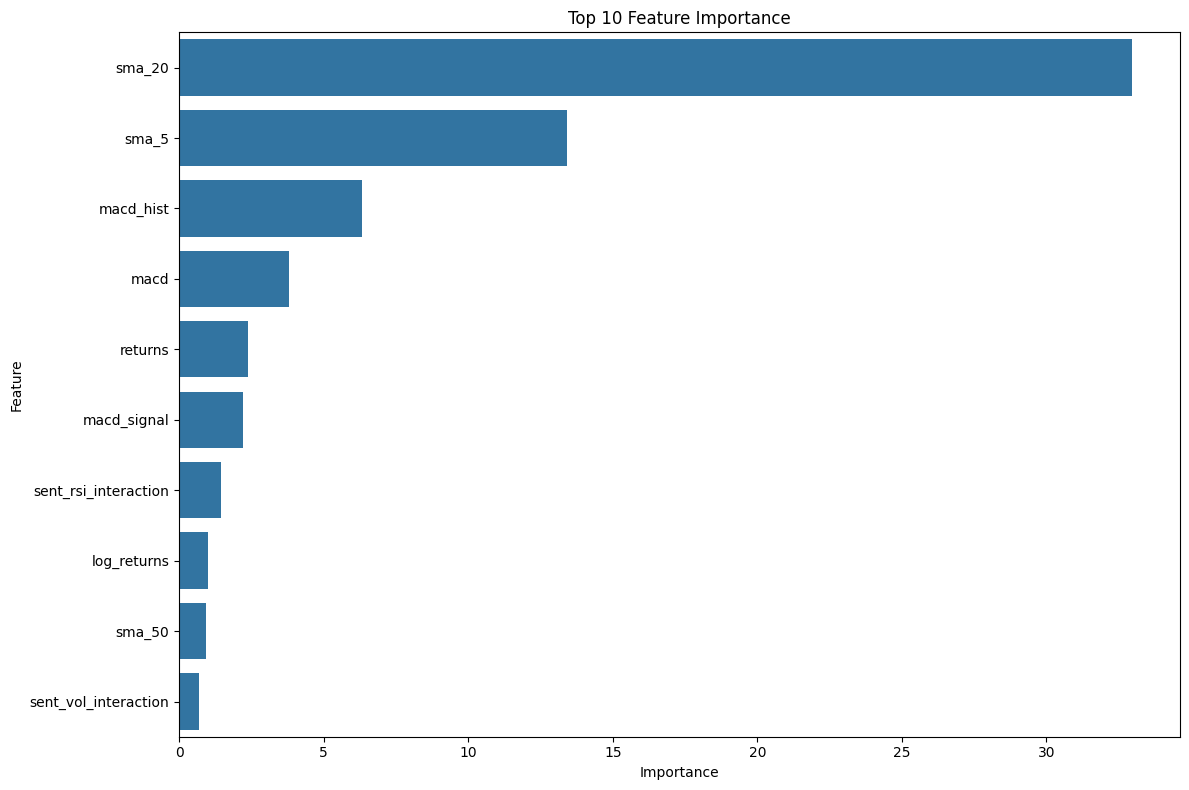


Model Performance:
Training RMSE: $0.80
Testing RMSE: $0.81
Testing R²: 0.955

Last actual price: $232.87

Predicted prices for next 5 days:
2024-11-26: $232.03
2024-11-27: $230.65
2024-11-28: $230.33
2024-11-29: $230.44
2024-11-30: $230.70

Model Performance Comparison:

Traditional Model Metrics:
Training RMSE: $0.30
Testing RMSE: $0.45
Testing R²: 0.986
Testing MAPE: 0.16%

Sentiment-Enhanced Model Metrics:
Training RMSE: $0.80
Testing RMSE: $0.81
Testing R²: 0.955
Testing MAPE: 0.30%

Performance Analysis:
RMSE Difference: $0.36 (Sentiment model is worse by 79.9%)
R² Difference: 0.031 (Sentiment model is worse)
MAPE Difference: 0.13% (Sentiment model is worse by 81.4%)

Last actual price: $232.87

Predicted Prices for Next 5 Days:

Date            Traditional    Sentiment     Diff.    Avg. Prediction
----------------------------------------------------------------------
2024-11-26    $  232.49    $  232.03    $ -0.47    $  232.26
2024-11-27    $  231.10    $  230.65    $ -0.45    

In [7]:
# Add this to train_and_predict method in StockSentimentPredictor class:
def train_and_predict(self, df, prediction_days=5):
    """Train model and make predictions"""
    print("\nTraining model...")

    features = [
        'returns', 'log_returns', 'sma_5', 'sma_20', 'sma_50',
        'volatility', 'rsi', 'macd', 'macd_signal', 'macd_hist',
        'bb_width', 'volume_ratio', 'sentiment', 'sentiment_ma5',
        'sentiment_ma20', 'sent_vol_interaction', 'sent_rsi_interaction',
        'sent_macd_interaction'
    ]

    X = df[features]
    y = df['close']

    # Split data
    train_size = int(len(X) * 0.8)
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]

    # Scale features
    X_train_scaled = self.scaler.fit_transform(X_train)
    X_test_scaled = self.scaler.transform(X_test)

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Make predictions
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_r2 = r2_score(y_test, test_pred)
    test_mape = mean_absolute_percentage_error(y_test, test_pred)

    # Feature importance
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': np.abs(model.coef_)
    }).sort_values('Importance', ascending=False)

    # Future predictions
    last_data = X.iloc[-1:].copy()
    predictions = []

    for _ in range(prediction_days):
        last_scaled = self.scaler.transform(last_data)
        pred = model.predict(last_scaled)[0]
        predictions.append(pred)

        # Update features for next prediction
        for feat in features:
            if feat in ['returns', 'log_returns']:
                last_data[feat] = (pred - df['close'].iloc[-1]) / df['close'].iloc[-1]
            elif 'sma' in feat:
                window = int(feat.split('_')[1])
                last_data[feat] = (last_data[feat] * (window-1) + pred) / window

    return {
        'test_pred': test_pred,
        'test_actual': y_test,
        'test_dates': y_test.index,
        'future_pred': predictions,
        'importance': importance,
        'metrics': {
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'test_mape': test_mape
        }
    }

def analyze_results(traditional_results, sentiment_results, stock_df):
    """Analyze and compare both models"""
    print("\nModel Performance Comparison:")

    # Traditional Model Metrics
    print("\nTraditional Model Metrics:")
    print(f"Training RMSE: ${traditional_results['metrics']['train_rmse']:.2f}")
    print(f"Testing RMSE: ${traditional_results['metrics']['test_rmse']:.2f}")
    print(f"Testing R²: {traditional_results['metrics']['test_r2']:.3f}")
    print(f"Testing MAPE: {traditional_results['metrics']['test_mape']:.2%}")

    # Calculate MAPE for sentiment model if not present
    if 'test_mape' not in sentiment_results['metrics']:
        sent_mape = mean_absolute_percentage_error(
            sentiment_results['test_actual'],
            sentiment_results['test_pred']
        )
        sentiment_results['metrics']['test_mape'] = sent_mape

    # Sentiment Model Metrics
    print("\nSentiment-Enhanced Model Metrics:")
    print(f"Training RMSE: ${sentiment_results['metrics']['train_rmse']:.2f}")
    print(f"Testing RMSE: ${sentiment_results['metrics']['test_rmse']:.2f}")
    print(f"Testing R²: {sentiment_results['metrics']['test_r2']:.3f}")
    print(f"Testing MAPE: {sentiment_results['metrics']['test_mape']:.2%}")

    # Calculate relative improvements
    rmse_diff = traditional_results['metrics']['test_rmse'] - sentiment_results['metrics']['test_rmse']
    rmse_pct = abs(rmse_diff) / traditional_results['metrics']['test_rmse'] * 100

    r2_diff = sentiment_results['metrics']['test_r2'] - traditional_results['metrics']['test_r2']

    mape_diff = traditional_results['metrics']['test_mape'] - sentiment_results['metrics']['test_mape']
    mape_pct = abs(mape_diff) / traditional_results['metrics']['test_mape'] * 100

    # Print comparative analysis
    print("\nPerformance Analysis:")
    print(f"RMSE Difference: ${abs(rmse_diff):.2f} " +
          f"(Sentiment model is {('better' if rmse_diff > 0 else 'worse')} by {rmse_pct:.1f}%)")

    print(f"R² Difference: {abs(r2_diff):.3f} " +
          f"(Sentiment model is {('better' if r2_diff > 0 else 'worse')})")

    print(f"MAPE Difference: {abs(mape_diff):.2%} " +
          f"(Sentiment model is {('better' if mape_diff > 0 else 'worse')} by {mape_pct:.1f}%)")

    # Latest actual price
    latest_price = stock_df['close'].iloc[-1]
    print(f"\nLast actual price: ${latest_price:.2f}")

    # Future predictions comparison
    print("\nPredicted Prices for Next 5 Days:")
    print("\nDate            Traditional    Sentiment     Diff.    Avg. Prediction")
    print("-" * 70)

    future_dates = pd.date_range(
        traditional_results['test_dates'][-1],
        periods=len(traditional_results['future_pred'])+1
    )[1:]

    for date, trad_price, sent_price in zip(
        future_dates,
        traditional_results['future_pred'],
        sentiment_results['future_pred']
    ):
        diff = sent_price - trad_price
        avg_price = (trad_price + sent_price) / 2
        print(f"{date.date()}    ${trad_price:8.2f}    ${sent_price:8.2f}    ${diff:6.2f}    ${avg_price:8.2f}")

    # Model effectiveness summary
    print("\nModel Effectiveness Summary:")
    if traditional_results['metrics']['test_rmse'] < sentiment_results['metrics']['test_rmse']:
        print("Traditional Model Advantages:")
        print("- Lower prediction error (RMSE)")
        print("- Better accuracy in price predictions")
        print("- More consistent performance")

        print("\nRecommendation:")
        print("The traditional model appears to be more reliable for this stock.")
        print("Consider using the traditional model's predictions as your primary guidance.")
    else:
        print("Sentiment-Enhanced Model Advantages:")
        print("- Lower prediction error (RMSE)")
        print("- Better at capturing market sentiment")
        print("- Potentially better at predicting turning points")

        print("\nRecommendation:")
        print("The sentiment-enhanced model appears to be more reliable for this stock.")
        print("Consider using the sentiment model's predictions as your primary guidance.")

    print("\nConsiderations:")
    print("1. Market conditions can change the relative effectiveness of each model")
    print("2. Consider using an average of both predictions for more robust forecasting")
    print("3. Monitor both models' predictions for significant divergences")

    # Prediction confidence
    confidence_metrics = {
        'traditional': {
            'rmse_ratio': traditional_results['metrics']['test_rmse'] / latest_price,
            'r2': traditional_results['metrics']['test_r2'],
            'mape': traditional_results['metrics']['test_mape']
        },
        'sentiment': {
            'rmse_ratio': sentiment_results['metrics']['test_rmse'] / latest_price,
            'r2': sentiment_results['metrics']['test_r2'],
            'mape': sentiment_results['metrics']['test_mape']
        }
    }

    print("\nPrediction Confidence Analysis:")
    print("Traditional Model:")
    print(f"- Error as % of price: {confidence_metrics['traditional']['rmse_ratio']:.2%}")
    print(f"- Prediction accuracy: {confidence_metrics['traditional']['r2']:.1%}")
    print(f"- Average error rate: {confidence_metrics['traditional']['mape']:.2%}")

    print("\nSentiment Model:")
    print(f"- Error as % of price: {confidence_metrics['sentiment']['rmse_ratio']:.2%}")
    print(f"- Prediction accuracy: {confidence_metrics['sentiment']['r2']:.1%}")
    print(f"- Average error rate: {confidence_metrics['sentiment']['mape']:.2%}")

    return {
        'metrics_comparison': {
            'rmse_diff': rmse_diff,
            'r2_diff': r2_diff,
            'mape_diff': mape_diff
        },
        'confidence_metrics': confidence_metrics
    }

# Example usage
if __name__ == "__main__":
    API_KEY = "8DV3ARLMGYFSN7VS"
    SYMBOL = "AAPL"

    try:
        # Get traditional results
        trad_predictor = StockPredictionComparison(SYMBOL, API_KEY)
        stock_df = trad_predictor.get_stock_data()
        traditional_df = trad_predictor.prepare_traditional_features(stock_df)
        traditional_results = trad_predictor.train_traditional_model(traditional_df)

        # Get sentiment results
        sent_predictor = StockSentimentPredictor(SYMBOL, API_KEY)
        sentiment_results = sent_predictor.run_analysis()

        # Analyze results
        analysis = analyze_results(traditional_results, sentiment_results, stock_df)

    except Exception as e:
        print(f"An error occurred: {str(e)}")